# Faster R-CNN experiments
This file contains experiments for my Faster R-CNN implementation. To access GPUs/TPUs, I ran this file in Google Colaboratory.

## Setup
To pull from the GitHub repository in Colab:
```
%cd drive/MyDrive/Conservation\ Research/Code/counting-cranes
!git add .
!git stash
!git pull
```
----

In [1]:
#Mounting Google Drive...
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Will have to restart runtime after running this cell!
!pip install -r "/content/drive/MyDrive/Conservation Research/Code/counting-cranes/requirements.txt"

     |████████████████████████████████| 804.1MB 22kB/s 
     |████████████████████████████████| 17.4MB 34kB/s 
     |████████████████████████████████| 7.1MB 25.1MB/s 
     |████████████████████████████████| 2.2MB 41.8MB/s 
     |████████████████████████████████| 17.4MB 147kB/s 
     |████████████████████████████████| 102kB 14.8MB/s 
     |████████████████████████████████| 15.3MB 120kB/s 
     |████████████████████████████████| 11.6MB 266kB/s 
     |████████████████████████████████| 808kB 35.7MB/s 
     |████████████████████████████████| 8.3MB 35.1MB/s 
     |████████████████████████████████| 27.4MB 117kB/s 
     |████████████████████████████████| 51.0MB 155kB/s 
     |████████████████████████████████| 38.2MB 81kB/s 
     |████████████████████████████████| 10.6MB 44.3MB/s 
     |████████████████████████████████| 122kB 58.8MB/s 
     |████████████████████████████████| 276kB 59.1MB/s 
     |████████████████████████████████| 829kB 45.5MB/s 
     |████████████████████████████████| 59.9MB 13

In [1]:
import json

config = json.load(open('/content/drive/MyDrive/Conservation Research/Code/counting-cranes/config.json', 'r'))
DATA_FP = config['data_filepath_colab']
CODE_FP = config['code_filepath_colab']
MODEL_SAVE_FP = config['model_saves_filepath_colab']
SEED = config['random_seed']
HYPERPARAMETERS = config['faster_rcnn_params']

In [10]:
import sys
import os
sys.path.append(CODE_FP) 
sys.path.append(os.path.join(CODE_FP, 'object_detection'))

from faster_rcnn_model import *
from bird_dataset import *

import torch
from torch.utils.data import DataLoader
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import time

## Model training
If the Colab runtime disconnects, you'll have to load from a post-epoch `PyTorch Lightning` model save.

In [3]:
#Setting our random seed for all operations (PyTorch, numpy, python.random)
#  especially important if Colab exits the runtime... ensures that we get the same train/val/test split!
seed_everything(SEED);

Global seed set to 1693


In [4]:
#Selecting hyperparams for this run
tile_size = tuple(config['tile_size'])
HYPERPARAMETERS

{'batch_size': 1,
 'constructor_hyperparams': {'box_detections_per_img': 500,
  'box_nms_thresh': 0.3},
 'iou_threshold_EVALUATION': 0.3,
 'learning_rate': 0.001}

In [5]:
#Creating a dataset and subsetting into train/validation/test splits - run the "seed_everything" directly before this cell!
bird_dataset_train = BirdDataset(root_dir = DATA_FP, 
                                 transforms = get_transforms('object_detection', train = True), 
                                 tiling_method = 'random', #random tiling for training
                                 num_tiles = 5, 
                                 max_neg_examples = 1, 
                                 tile_size = tile_size)
bird_dataset_eval = BirdDataset(root_dir = DATA_FP, 
                                transforms = get_transforms('object_detection', train = False), 
                                tiling_method = 'w_o_overlap', #tiling w/o overlap for validation/testing
                                tile_size = tile_size) 

#  here, we limit which PARENT images each set gets!
indices = torch.randperm(len(bird_dataset_train)).tolist()
dataset_train = torch.utils.data.Subset(bird_dataset_train, indices[ : 24]) #24 images in train
dataset_val = torch.utils.data.Subset(bird_dataset_eval, indices[24 : 28]) #4 images in val
dataset_test = torch.utils.data.Subset(bird_dataset_eval, indices[28 : ]) #6 images in test

In [6]:
#Wrapping our train/validation/test sets in DataLoaders
dataloader_train = DataLoader(dataset_train, batch_size = HYPERPARAMETERS['batch_size'], shuffle = True, collate_fn = collate_tiles_object_detection) 
dataloader_val = DataLoader(dataset_val, batch_size = HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_tiles_object_detection) 
dataloader_test = DataLoader(dataset_test, batch_size = HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_tiles_object_detection) 

In [7]:
#Instantiating the pre-trained model and wrapping it in PyTorch Lightning class
model = get_faster_rcnn(backbone = 'ResNet50', num_classes = 2, pretrained = False, **HYPERPARAMETERS['constructor_hyperparams']) #class 0 is reserved for background (may not be necessary) + class 1 is bird class
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate'], iou_threshold = HYPERPARAMETERS['iou_threshold_EVALUATION']) #IoU threshold will be used for validation AP!
pl_model; #checking out the model summary

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [8]:
#Setting up logger 
logging_directory = os.path.join(MODEL_SAVE_FP, 'faster_rcnn', 'evaluation')
logger = CSVLogger(logging_directory, name = 'experiments_6.25.2021') #REMEMBER: change this when you shift experiments!

In [11]:
#Training the model w/early stopping on val metrics
checkpoint_dir = os.path.join(MODEL_SAVE_FP, 'faster_rcnn', 'trainer_checkpoints')

# save_callback = ModelCheckpoint(monitor = 'Val_MAE', mode = 'min', dirpath = os.path.join(MODEL_SAVE_FP, 'faster_rcnn'), filename = 'faster_rcnn_40_epochs_w_checkpoint_6.25.2021')
lr_callback = LearningRateMonitor(logging_interval = 'step')

trainer = Trainer(gpus = 1, max_epochs = 40, callbacks = [lr_callback], default_root_dir = checkpoint_dir, logger = logger)
trainer.fit(pl_model, train_dataloader = dataloader_train, val_dataloaders = dataloader_val)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)


Global seed set to 1693


In [ ]:
#Saving the model
save_name = 'faster_rcnn_40_epochs_6.23.2021.pth'
torch.save(model.state_dict(), os.path.join(MODEL_SAVE_FP, 'faster_rcnn', 'final_models', save_name))

## Qualitatively inspecting predictions from the trained model
To avoid memory errors, we have to save and load the model. Make sure to restart the runtime!

In [17]:
#Loading the model
save_name = 'model1_6.23.2021.pth'
model = get_faster_rcnn(backbone = 'ResNet50', num_classes = 2, **HYPERPARAMETERS['constructor_hyperparams'])
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_FP, 'faster_rcnn', '40_epoch_runs', save_name)))
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate']) 

In [18]:
#Predicting on one parent image - this is currently happening on CPU... prediction w/PyTorch Lightning's trainer seems not to work correctly!
images, targets, _, _ = next(iter(dataloader_test))
images, targets = images[0 : 10], targets[0 : 10] 
preds = pl_model(images)

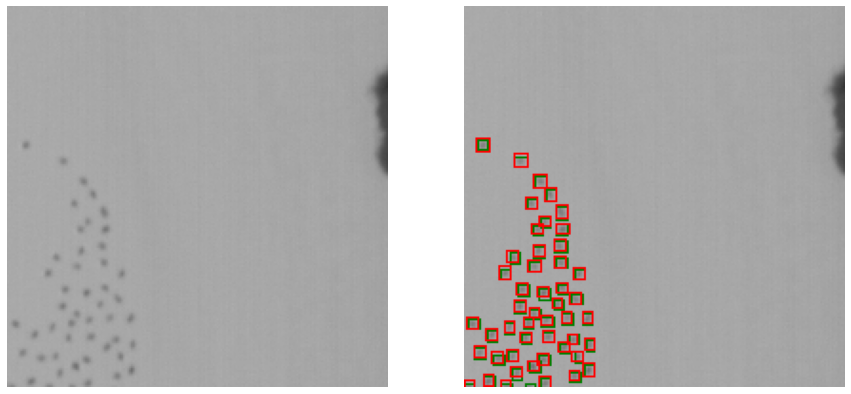

In [33]:
#Plotting an image and predicted bboxes
index = 5
img = np.moveaxis(images[index].numpy(), 0, -1) * 255
pred_bboxes = preds[index]['boxes'].tolist()
gt_bboxes = targets[index]['boxes'].tolist()

pil_img = Image.fromarray(np.copy(img).astype(np.uint8))
draw = ImageDraw.Draw(pil_img)
for b in gt_bboxes:
    draw.rectangle(b, outline = 'green', width = 1)
for b in pred_bboxes:
    draw.rectangle(b, outline = 'red', width = 1)
img_w_boxes = np.array(pil_img)

f, axarr = plt.subplots(1, 2, figsize = (15, 10))
axarr[0].imshow(img.astype(np.uint8))
axarr[1].imshow(img_w_boxes)
for a in axarr:
    a.axis('off')

In [ ]:
#Checking counts
print(f'We predicted {len(bboxes)} birds and there are actually {len(targets[index]["boxes"])} birds in this image')

We predicted 14 birds and there are actually 0 birds in this image


## Model testing

In [14]:
#Loading the model
save_name = 'model1_6.23.2021.pth'
model = get_faster_rcnn(backbone = 'ResNet50', num_classes = 2, **HYPERPARAMETERS['constructor_hyperparams']) 
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_FP, 'faster_rcnn', '40_epoch_runs', save_name)))
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate'], iou_threshold = HYPERPARAMETERS['iou_threshold_EVALUATION'])

In [12]:
#ALTERNATIVE: load the model using a PyTorch Lightning checkpoint
save_name = 'faster_rcnn_40_epochs_w_checkpoint_6.25.2021.ckpt'
model = get_faster_rcnn(backbone = 'ResNet50', num_classes = 2, **HYPERPARAMETERS['constructor_hyperparams']) 
pl_model = FasterRCNNLightning.load_from_checkpoint(os.path.join(MODEL_SAVE_FP, 'faster_rcnn', save_name), model = model, lr = HYPERPARAMETERS['learning_rate'])

In [15]:
#Using the saved model and the test set to evaluate (via AP)
trainer = Trainer(gpus = 1)
results = trainer.test(pl_model, test_dataloaders = dataloader_test)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test_AP': 0.7154048832427822,
 'Test_FP': 914.0,
 'Test_MAE': 384.6666666666667,
 'Test_MPE': 0.21596474712639313,
 'Test_RMSE': 769.3575241719548,
 'Test_TP': 6265.0}
--------------------------------------------------------------------------------


In [ ]:
#Checking prediction speed w/out PyTorch Lightning
images, targets, _, _ = next(iter(dataloader_test))
images = [i.to('cuda') for i in images[0 : 10]]

model = model.to('cuda')
model.eval()
start = time.time()
preds = model(images)
print(f'Prediction took {round(time.time() - start, 3)} seconds, or {round((time.time() - start) / len(images), 3)} seconds per image')

Prediction took 0.943 seconds, or 0.094 seconds per image
